### CITS4402 Project: Histograms of Oriented Gradients for Human Detection
#### Group member: Franco Meng 23370209, Laine Mulvay 22708032
#### Date: 20-May-2025

In [212]:
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import io, color
from scipy import ndimage
from icrawler.builtin import GoogleImageCrawler
from PIL import ImageTk, Image
from icrawler.downloader import ImageDownloader
import os
import random
from skimage.feature import hog
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import det_curve, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import RocCurveDisplay, confusion_matrix, DetCurveDisplay
from sklearn.metrics.pairwise import cosine_similarity

In [213]:

# folder1 = "Submission/Others/Dataset_1105/Final/human_train"
# folder2 = "Submission/Others/Dataset_1105/Final/human_test"
# #folder1 = "Submission/Others/Dataset_1105/Final/non_human_train"
# #folder2 = "Submission/Others/Dataset_1105/Final/non_human_test"
# def check_unique_files(folder1, folder2):
#     files1 = set(os.listdir(folder1))
#     files2 = set(os.listdir(folder2))

#     duplicates = files1.intersection(files2)

#     if duplicates:
#         print("Duplicates:")
#         for i in duplicates:
#             print(f"- {i}")
#     else:
#         print("no duplicates.")

# check_unique_files(folder1, folder2)

#### Phase 1: Dataset Building

In [214]:
#pip install icrawler pillow opencv-python

In [215]:
#Below two lines scraping images from google images.
#google_crawler = GoogleImageCrawler(storage={'root_dir': 'empty_street_images'})
#google_crawler.crawl(keyword='no human city road', max_num=10)

In [216]:
#Below funtion just to segment image into patches. for negative samples.
# def segment_images(input_dir, output_dir, patch_size=(64, 128), max_size = (320, 640)):
#     os.makedirs(output_dir, exist_ok=True)
#     count = 0
#     for file in os.listdir(input_dir):
#         if file.endswith(('.jpg', '.png', '.jpeg')):
#             try:
#                 img = Image.open(os.path.join(input_dir, file)).convert('RGB')
#                 img.thumbnail(max_size)
#                 width, height = img.size
#                 for top in range(0, height, patch_size[1]):
#                     for left in range(0, width, patch_size[0]):
#                         box = (left, top, left + patch_size[0], top + patch_size[1])
#                         patch = img.crop(box)
#                         if patch.size == patch_size:
#                             patch.save(os.path.join(output_dir, f"patch_{count}.jpg"))
#                             count += 1
#             except Exception as e:
#                 print(f"Failed on {file}: {e}")

In [217]:
#segment_images('empty_street_images_6', 'non_human_patches_6')

#### Phase 2: Feature Extraction and SVM Training

In [218]:
#below function is to compute_grad
def compute_grad(np_image, filter_ = "default" ):
    image=np.float32(np_image) 
    #Here designed 3 different kernels for ablation study.
    if filter_ == "Sobel":
        kernel_x=np.array([[-1, 0, 1],
                           [-2, 0, 2],
                           [-1, 0, 1]], dtype=np.float32)
        kernel_y=np.array([[-1, -2, -1],
                           [ 0,  0,  0],
                           [ 1,  2,  1]], dtype=np.float32)
    elif filter_ == "Prewitt":
        kernel_x = np.array([[-1, 0, 1],
                             [-1, 0, 1],
                             [-1, 0, 1]], dtype=np.float32)
        kernel_y = np.array([[-1, -1, -1],
                             [ 0,  0,  0],
                             [ 1,  1,  1]], dtype=np.float32)     
    else:
        kernel_x = np.array([[-1, 0, 1]], dtype=np.float32) #use [-1,0,1] filter without smoothing as required in default settings
        kernel_y = np.array([[-1],
                             [0], 
                             [1]], dtype=np.float32) #use [-1,0,1] filter without smoothing as required 
    grad_x = cv2.filter2D(image, -1, kernel_x) #filter applied on x direction
    grad_y = cv2.filter2D(image, -1, kernel_y) #filter applied on y direction
    
    mag, ang = cv2.cartToPolar(grad_x, grad_y, angleInDegrees = True) #use CV2's cartToPolar to get magtitude and angel (in 360 degree)
    #based on the documentation found on the CV2 webpage: The angles are calculated with accuracy about 0.3 degrees. 
    #https://docs.opencv.org/3.0-beta/modules/core/doc/operations_on_arrays.html#carttopolar 
    return mag, ang

In [219]:
#below function is to compute_histogram, with number_bins default to 9 and angel default to 0-180
def compute_histogram(mag_cell, ang_cell, num_bins=9, angle_ = 180):
    bin_size = angle_ // num_bins # Oritation Bin (change for Ablation Study)
    histogram = np.zeros(num_bins) # create a container for histogram
    for i in range(mag_cell.shape[0]): #iterate each mag and ang cell then put in the correct bin for histogram
        for j in range(mag_cell.shape[1]):
            mag = mag_cell[i, j]  
            if angle_ == 180: # (change for Ablation Study)
                ang = ang_cell[i, j]
                ang = ang % 180 #convert 360 degree to 180 degree, from signed angle to un-signed angle
            else:
                ang = ang_cell[i, j]
            bin_ = int(ang // bin_size) % num_bins
            histogram[bin_] += mag  #put gradient value into oritation bin
    return histogram

In [220]:
#below is the main function will be used to compute hog features with input images. 
#with cell_size default as 8x8, block_size default as 16x16 as required.
def compute_hog(image, cell_size=8, block_size=16, num_bins=9, block_stride = 1,filter_ = "default", angle_ = 180 ): #(Change Settings for Ablation Study)
    
    height, width = image.shape
    mag, ang = compute_grad(image,filter_ )
    number_of_Xcells = width // cell_size #how many cells in X 
    number_of_Ycells = height // cell_size #how many cells in Y

    cell_histograms = np.zeros((number_of_Ycells, number_of_Xcells, num_bins)) 

    for y in range(number_of_Ycells):
        for x in range(number_of_Xcells):
            y1 = y * cell_size  #Starting Index of Y
            y2 = y1 + cell_size #Ending Index of Y
            x1 = x * cell_size  #Starting Index of X
            x2 = x1 + cell_size #Ending Index of X

            mag_cell = mag[y1:y2, x1:x2] #extract correct section of magtitude 
            ang_cell = ang[y1:y2, x1:x2] #extract correct section of angel

            cell_histograms[y, x, :] = compute_histogram(mag_cell, ang_cell, num_bins, angle_) #put result into the cell_histograms

    block_number = block_size // cell_size
    block_hist = []
    #sliding blocks on Y and X, here I've added step size, if cell size is 8, block size is 32, I can slide cell by cell 
    #or every second cell for the block nomalisation 
    for y in range(0, number_of_Ycells - block_number + 1, block_stride): 
        for x in range(0, number_of_Xcells - block_number + 1, block_stride):
            block = cell_histograms[y:y+block_number, x:x+block_number, :].flatten() #flatten into one vector
            eps = 1e-5 #to avoid divided by zero. 
            block_norm_1 = block / (np.linalg.norm(block) + eps)  #First normalisaiton
            block_norm_1 = np.clip(block_norm_1, 0, 0.2)  #Clip Lowe-style , mentioned in paper : Lowe's Scale Invariant Feature Transformation (SIFT)
            block_norm_2 = block_norm_1 / (np.linalg.norm(block_norm_1) + eps) #Second normalisation
            block_hist.append(block_norm_2) 

    return np.concatenate(block_hist)

In [221]:
#!pip install openpyxl


In [222]:
#below part is to use a single image to test the result of HOG feature vector, and to compare the 
#the final HOG feature result between above written algorithms versus HOG function from Skimage Package

In [223]:
original_image = Image.open('00019_male_fore.jpg')
np_image = np.array(original_image.convert('L'))
np_image=np.float32(np_image)

In [224]:
features_selfwritten = compute_hog(np_image, cell_size=8, block_size=16, num_bins=9, block_stride = 1,filter_ = "default", angle_ = 180)
features_selfwritten

array([0.2287903 , 0.01887137, 0.18174986, ..., 0.109938  , 0.12521594,
       0.14697448])

In [225]:
#HOG is from skimage.feature https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_hog.html
features = hog(
    np_image,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    block_norm='L2-Hys',
    transform_sqrt=False,  # no gamma correction
    visualize=False,
    feature_vector=True
)
features

array([0.22879349, 0.01887163, 0.18175238, ..., 0.10993935, 0.12521748,
       0.14697629], dtype=float32)

In [226]:
#By comparing HOG function from SKimage, with selfwritten function, two HOG final output vectors are basically identical
print("Cosine similarity:", cosine_similarity([features], [features_selfwritten])[0][0])

Cosine similarity: 0.9999999999976311


In [227]:
#human_dir_train = 'Dataset/human_training'
#non_human_dir_train = 'Dataset/non_human_training'

#human_dir_test = 'Dataset/human_testing'
#non_human_dir_test = 'Dataset/non_human_testing'

human_dir_train = 'Submission/Others/Dataset_1105/Final/human_train'
non_human_dir_train = 'Submission/Others/Dataset_1105/Final/non_human_train'

human_dir_test = 'Submission/Others/Dataset_1105/Final/human_test'
non_human_dir_test = 'Submission/Others/Dataset_1105/Final/non_human_test'


image_size = (64, 128)  

def load_images(folder, label, sample_size):
    files = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    selected_files = random.sample(files, sample_size)

    data = []
    labels = []
    file_names = []

    for file in selected_files:
        path = os.path.join(folder, file)
        original_image = Image.open(path)
        np_image = np.array(original_image.convert('L'))
        np_image = cv2.resize(np_image, image_size)

        data.append(np_image)
        labels.append(label)
        file_names.append(file)

    return data, labels, file_names

In [228]:
#below is to prepare training sets for linear SVM

In [259]:
random.seed(1245)
human_data, human_labels, file_names_human = load_images(human_dir_train, label=1, sample_size=250)
non_human_data, non_human_labels, file_names_non_human = load_images(non_human_dir_train, label = 0, sample_size =250)

In [260]:
feature_human = [compute_hog(i, filter_ = "Default", num_bins=18, angle_ = 360, cell_size=8, block_size=32) for i in human_data]
feature_non_human = [compute_hog(i, filter_ = "Default", num_bins=18, angle_ = 360, cell_size=8, block_size=32) for i in non_human_data]
#feature_human = [compute_hog(i) for i in human_data]
#feature_non_human = [compute_hog(i) for i in non_human_data]
predictor = np.array(feature_human + feature_non_human)
response = np.array(human_labels + non_human_labels)
response2 = np.array(file_names_human + file_names_non_human)

In [261]:
#below is to prepare testing sets 

In [262]:
random.seed(12451)
human_data_test, human_labels_test, file_names_human_test = load_images(human_dir_test, label=1, sample_size=160)
non_human_data_test, non_human_labels_test, file_names_non_human_test = load_images(non_human_dir_test, label = 0, sample_size =160)

In [263]:
feature_human_test = [compute_hog(i, filter_ = "Default", num_bins=18, angle_ = 360, cell_size=8, block_size=32) for i in human_data_test]
feature_non_human_test = [compute_hog(i, filter_ = "Default", num_bins=18, angle_ = 360, cell_size=8, block_size=32) for i in non_human_data_test]
#feature_human_test = [compute_hog(i) for i in human_data_test]
#feature_non_human_test = [compute_hog(i) for i in non_human_data_test]
predictor_test = np.array(feature_human_test + feature_non_human_test)
response_test = np.array(human_labels_test + non_human_labels_test)
response2_test = np.array(file_names_human_test + file_names_non_human_test)

In [234]:
# Below is to build LinearSVC

In [274]:
clf = LinearSVC()
clf.fit(predictor, response)

y_pred = clf.predict(predictor_test)
print("Accuracy:", accuracy_score(response_test, y_pred))

Accuracy: 0.921875


In [265]:
# Evaluate Model Performance on the testing set
# ROC curve

In [266]:
#fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

clf = LinearSVC()
clf.fit(predictor, response)

#RocCurveDisplay.from_estimator(clf, predictor_test, response_test, ax=ax_roc)

LinearSVC()

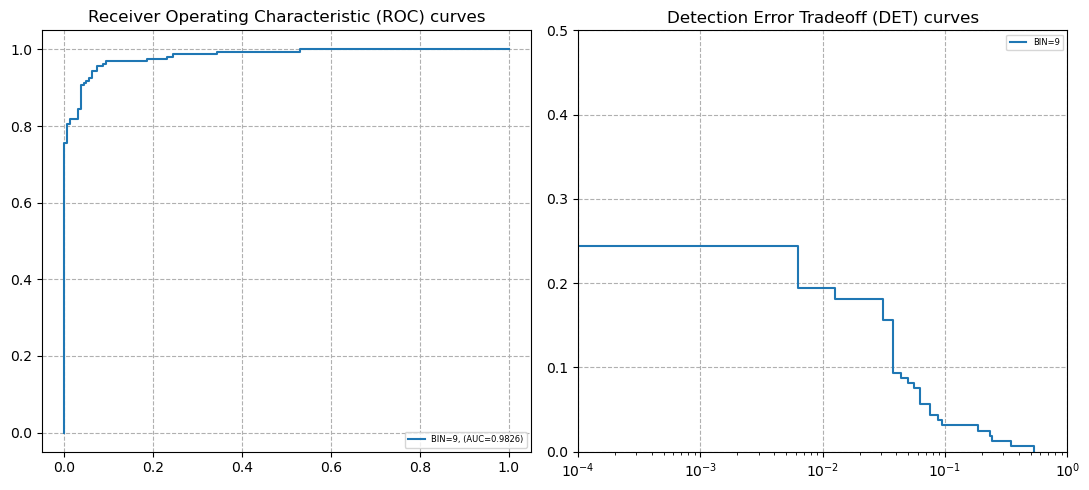

In [267]:


fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

# clf = LinearSVC()
# clf.fit(predictor, response)

#RocCurveDisplay.from_estimator(clf, predictor_test, response_test, ax=ax_roc)
#DetCurveDisplay.from_estimator(clf, predictor_test, response_test, ax=ax_det)

y_scores = clf.decision_function(predictor_test)





fpr, tpr, _ = roc_curve(response_test, y_scores)
roc_auc = auc(fpr, tpr)
ax_roc.plot(fpr, tpr, label=f"BIN=9, (AUC={roc_auc:.4f})")




#y_scores = clf.decision_function(predictor_test)
fpr, fnr, _ = det_curve(response_test, y_scores)
fpr = np.clip(fpr, 1e-6, None)
ax_det.plot(fpr, fnr, label=f"BIN=9")



ax_det.set_xscale('log')
#ax_roc.set_xscale('log')
ax_det.set_ylim(0, 0.5)
#ax_roc.set_ylim(bottom = 0.8)
ax_det.set_xlim([1e-4, 1e0])
#ax_roc.set_xlim([1e-4, 1e0])
ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")
ax_roc.grid(True, linestyle='--')
ax_det.grid(True, linestyle='--')
ax_roc.legend()
ax_det.legend()
ax_roc.legend(fontsize=6, loc = 'lower right')  
ax_det.legend(fontsize=6, loc = 'upper right')
plt.tight_layout()
plt.show()

In [268]:
confusion_matrix(response_test,y_pred)

array([[154,   6],
       [ 19, 141]], dtype=int64)

In [269]:
response_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [270]:
y_pred

array([1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [271]:
misclassificaton_list = np.where(y_pred != response_test)[0]
misclassificaton_list

array([  4,   6,  13,  20,  29,  32,  33,  56,  58,  59,  62,  88,  93,
       100, 131, 138, 145, 147, 149, 206, 236, 247, 274, 276, 280],
      dtype=int64)

In [272]:
misclassification_file_names = [response2_test[i] for i in misclassificaton_list]
misclassification_file_names 

['person_300_L2.jpg',
 'crop001833_L1.jpg',
 'crop001595_R1.jpg',
 'person_199_R1.jpg',
 'crop001838_R2.jpg',
 'crop001116_L1.jpg',
 'person_and_bike_143_L2.jpg',
 'crop001116_R1.jpg',
 'person_and_bike_147_R1.jpg',
 'crop001089_L1.jpg',
 'crop001841_L1.jpg',
 'crop001842_R1.jpg',
 'crop001560_R2.jpg',
 'person_128_L1.jpg',
 'crop001094_R1.jpg',
 'crop001230_R1.jpg',
 'crop001090_L1.jpg',
 'crop001144_L1.jpg',
 'crop001599_L1.jpg',
 'patch_88.jpg',
 'patch_36.jpg',
 'patch_86.jpg',
 'patch_17.jpg',
 'patch_79.jpg',
 'patch_12.jpg']

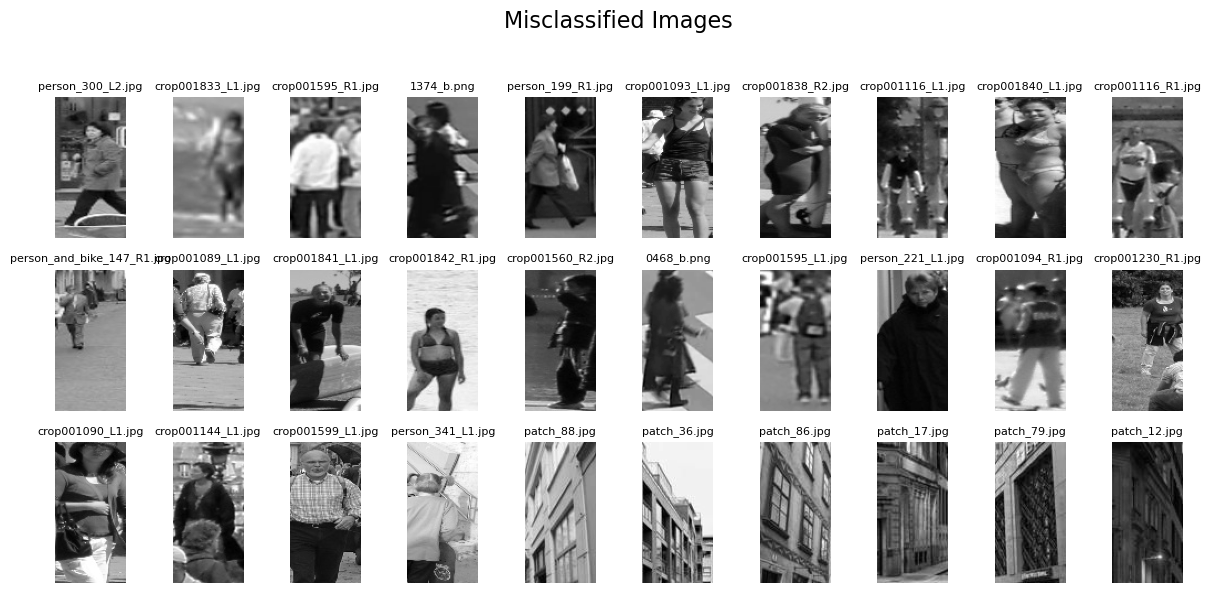

In [244]:
 
all_images =  human_data_test + non_human_data_test
misclassified_images = [all_images[i] for i in misclassificaton_list]  
plt.figure(figsize=(12, 6))
for idx, (img, fname) in enumerate(zip(misclassified_images, misclassification_file_names)):
    plt.subplot(3, 10, idx + 1)  
    plt.imshow(img, cmap='gray')
    plt.title(fname, fontsize=8)
    plt.axis('off')

plt.suptitle("Misclassified Images", fontsize=16)  
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

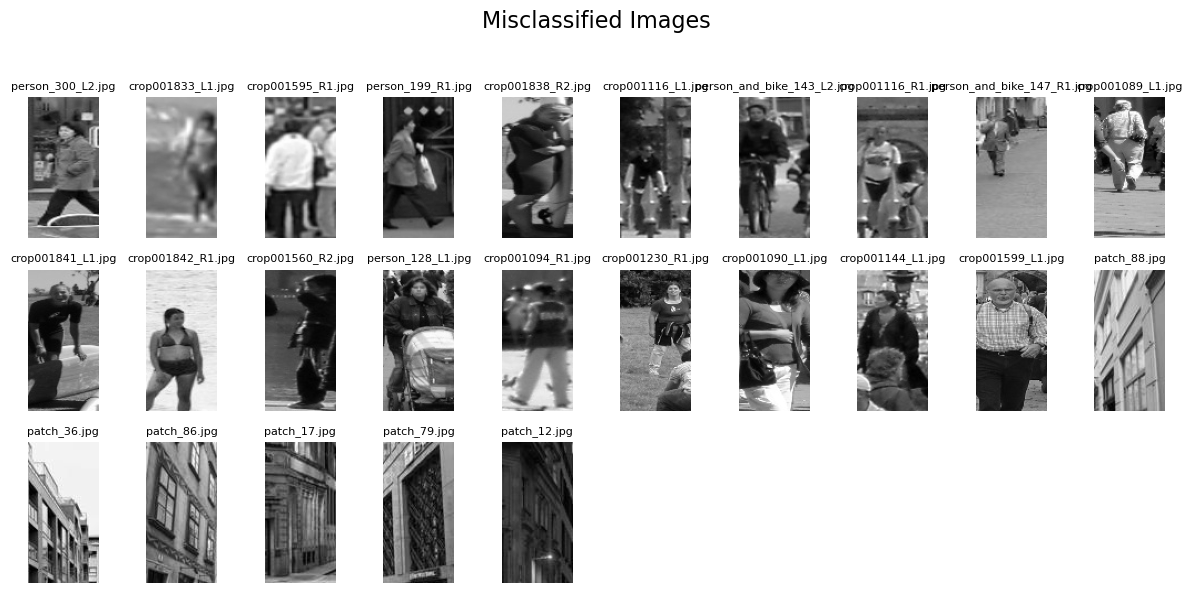

In [273]:
all_images =  human_data_test + non_human_data_test
misclassified_images = [all_images[i] for i in misclassificaton_list]  
plt.figure(figsize=(12, 6))
for idx, (img, fname) in enumerate(zip(misclassified_images, misclassification_file_names)):
    plt.subplot(3, 10, idx + 1)  
    plt.imshow(img, cmap='gray')
    plt.title(fname, fontsize=8)
    plt.axis('off')

plt.suptitle("Misclassified Images", fontsize=16)  
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

#### Phase 3: Ablation Study

##### 1. Filter/Smoothing Ablation Study

In [245]:
filter_list = ["Sobel", "Prewitt","Default"]

In [246]:
result_1 = []

for filter_i in filter_list:
    # Recompute HOG features with different bin size
    feature_human = [compute_hog(i, filter_ = filter_i) for i in human_data]
    feature_non_human = [compute_hog(i, filter_ = filter_i) for i in non_human_data]
    
    # Combine features and labels
    predictor = np.array(feature_human + feature_non_human)
    response = np.array(human_labels + non_human_labels)
    
    # Train the classifier
    clf = LinearSVC()
    clf.fit(predictor, response)
    
    # Compute test features using same bin size
    feature_human_test = [compute_hog(i, filter_ = filter_i) for i in human_data_test]
    feature_non_human_test = [compute_hog(i, filter_ = filter_i) for i in non_human_data_test]

    predictor_test = np.array(feature_human_test + feature_non_human_test)
    response_test = np.array(human_labels_test + non_human_labels_test)

    # accuracy 
    y_pred = clf.predict(predictor_test)
    acc = accuracy_score(response_test, y_pred)

    # Plot ROC curve
    y_scores = clf.decision_function(predictor_test)
    fpr_r, tpr_r, _ = roc_curve(response_test, y_scores)
    roc_auc = auc(fpr_r, tpr_r)


    #ax_roc.plot(fpr, tpr, label=f"Filter={filter_i}, (AUC={roc_auc:.4f})")


    # Plot DET curve
    fpr_d, fnr_d, _ = det_curve(response_test, y_scores)
    fpr_d = np.clip(fpr_d, 1e-6, None)

    result_1.append({
        "filter": filter_i,
        "fpr_roc": fpr_r,
        "tpr_roc": tpr_r,
        "roc_auc": roc_auc,
        "fpr_det": fpr_d,
        "fnr_det": fnr_d,
        "accuracy": acc
    })
    #ax_det.plot(fpr, fnr, label=f"Filter={filter_i}")



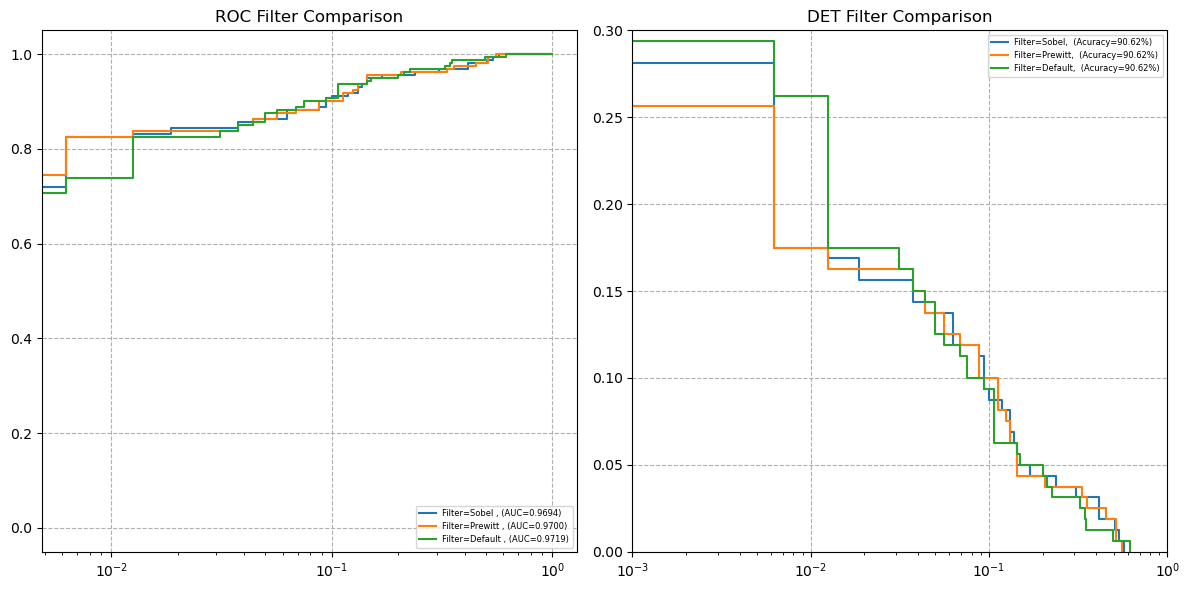

In [247]:
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(12, 6))


for i in result_1:
    ax_roc.plot(i["fpr_roc"], i["tpr_roc"], label=f"Filter={i['filter']} , (AUC={i['roc_auc']:.4f})")
    ax_det.plot(i["fpr_det"], i["fnr_det"], label=f"Filter={i['filter']},  (Acuracy={i['accuracy']:.2%})")


ax_roc.set_title("ROC Filter Comparison")
ax_det.set_title("DET Filter Comparison")

# Formatting plots
ax_det.set_xscale('log')
ax_roc.set_xscale('log')
ax_det.set_ylim(0, 0.3)
#ax_roc.set_ylim(bottom = 0.7)
ax_det.set_xlim([1e-3, 1e0])
#ax_roc.set_xlim([1e-3, 1e0])
ax_roc.grid(True, linestyle='--')
ax_det.grid(True, linestyle='--')
ax_roc.legend()
ax_det.legend()
ax_roc.legend(fontsize=6, loc = 'lower right')  
ax_det.legend(fontsize=6, loc = 'upper right')
plt.tight_layout()
plt.show()

##### 2. Bin Size / Angle (0-180 or 0-360) Ablation Study

In [248]:
bin_angel_pairs = [(3,180),(4,180),(6,180),(9,180),(12,180),(6,360),(8,360),(12,360),(18,360)]

In [249]:
result_2 = []

In [250]:
#fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(12, 6))
for bin_size, angle_degree in bin_angel_pairs:
    # Recompute HOG features with different bin size
    feature_human = [compute_hog(i, filter_ = "Default", num_bins=bin_size, angle_ = angle_degree) for i in human_data]
    feature_non_human = [compute_hog(i, filter_ = "Default", num_bins=bin_size, angle_ = angle_degree) for i in non_human_data]
    
    # Combine features and labels
    predictor = np.array(feature_human + feature_non_human)
    response = np.array(human_labels + non_human_labels)
    
    # Train the classifier
    clf = LinearSVC()
    clf.fit(predictor, response)
    
    # Compute test features using same bin size
    feature_human_test = [compute_hog(i, filter_ = "Default", num_bins=bin_size, angle_ = angle_degree) for i in human_data_test]
    feature_non_human_test = [compute_hog(i, filter_ = "Default", num_bins=bin_size, angle_ = angle_degree) for i in non_human_data_test]

    predictor_test = np.array(feature_human_test + feature_non_human_test)
    response_test = np.array(human_labels_test + non_human_labels_test)


    # accuracy 
    y_pred = clf.predict(predictor_test)
    acc = accuracy_score(response_test, y_pred)

    # Plot ROC curve
    y_scores = clf.decision_function(predictor_test)
    fpr_r, tpr_r, _ = roc_curve(response_test, y_scores)
    roc_auc = auc(fpr_r, tpr_r)

    # Plot DET curve
    fpr_d, fnr_d, _ = det_curve(response_test, y_scores)
    fpr_d = np.clip(fpr_d, 1e-6, None)

    result_2.append({
        "BIN": bin_size,
        "ANG": angle_degree,
        "fpr_roc": fpr_r,
        "tpr_roc": tpr_r,
        "roc_auc": roc_auc,
        "fpr_det": fpr_d,
        "fnr_det": fnr_d,
        "accuracy": acc
    })

    # Plot ROC curve
    #ax_roc.plot(fpr, tpr, label=f"BIN={bin_size}, ANG={angle_degree}° (AUC={roc_auc:.4f})")


    # Plot DET curve
    #ax_det.plot(fpr, fnr, label=f"BIN={bin_size}, ANG={angle_degree}°")

# ax_roc.set_title("ROC Curve (BIN & Angle Comparison)")
# ax_det.set_title("DET Curve (BIN & Angle Comparison)")



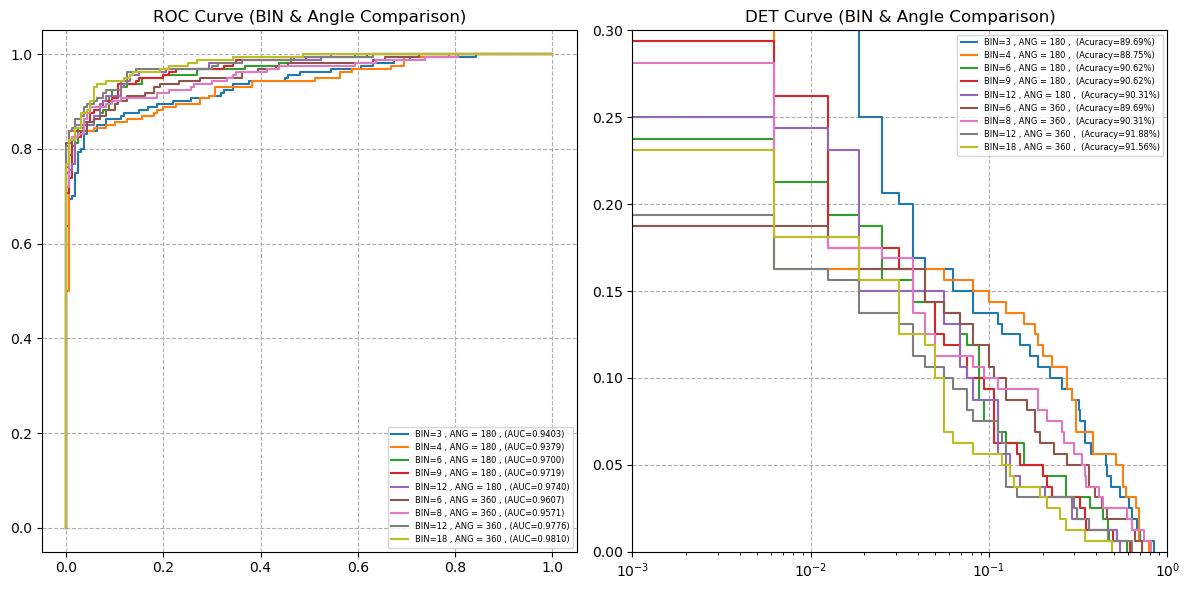

In [275]:
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(12, 6))


for i in result_2:
    ax_roc.plot(i["fpr_roc"], i["tpr_roc"], label=f"BIN={i['BIN']} , ANG = {i['ANG']} , (AUC={i['roc_auc']:.4f})")
    ax_det.plot(i["fpr_det"], i["fnr_det"], label=f"BIN={i['BIN']} , ANG = {i['ANG']} ,  (Acuracy={i['accuracy']:.2%})")


ax_roc.set_title("ROC Curve (BIN & Angle Comparison)")
ax_det.set_title("DET Curve (BIN & Angle Comparison)")

# Formatting plots
ax_det.set_xscale('log')
#ax_roc.set_xscale('log')
ax_det.set_ylim(0, 0.3)
#ax_roc.set_ylim(bottom = 0.7)
ax_det.set_xlim([1e-3, 1e0])
#ax_roc.set_xlim([1e-3, 1e0])
ax_roc.grid(True, linestyle='--')
ax_det.grid(True, linestyle='--')
ax_roc.legend()
ax_det.legend()
ax_roc.legend(fontsize=6, loc = 'lower right')  
ax_det.legend(fontsize=6, loc = 'upper right')
plt.tight_layout()
plt.show()

##### 3. Cell Size / Block Size Ablation Study

In [252]:
cell_block_list = [ (2,4), (2,6), (2,8), (2,16), (4,8), (4,16), (4,32), (8, 16), (8, 32), (16, 32) ]
result_3 = []

In [253]:
#fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(12, 6))
for c, b in cell_block_list:
    # Recompute HOG features with different bin size
    feature_human = [compute_hog(i, filter_ = "Default", num_bins=18, angle_ = 360, cell_size=c, block_size=b) for i in human_data]
    feature_non_human = [compute_hog(i, filter_ = "Default", num_bins=18, angle_ = 360, cell_size=c, block_size=b) for i in non_human_data]
    
    # Combine features and labels
    predictor = np.array(feature_human + feature_non_human)
    response = np.array(human_labels + non_human_labels)
    
    # Train the classifier
    clf = LinearSVC(max_iter=2000)
    clf.fit(predictor, response)
    
    # Compute test features using same bin size
    feature_human_test = [compute_hog(i, filter_ = "Default", num_bins=18, angle_ = 360, cell_size=c, block_size=b) for i in human_data_test]
    feature_non_human_test = [compute_hog(i, filter_ = "Default", num_bins=18, angle_ = 360, cell_size=c, block_size=b) for i in non_human_data_test]

    predictor_test = np.array(feature_human_test + feature_non_human_test)
    response_test = np.array(human_labels_test + non_human_labels_test)

    # accuracy 
    y_pred = clf.predict(predictor_test)
    acc = accuracy_score(response_test, y_pred)

    # Plot ROC curve
    y_scores = clf.decision_function(predictor_test)
    fpr_r, tpr_r, _ = roc_curve(response_test, y_scores)
    roc_auc = auc(fpr_r, tpr_r)

    # Plot DET curve
    fpr_d, fnr_d, _ = det_curve(response_test, y_scores)
    fpr_d = np.clip(fpr_d, 1e-6, None)

    result_3.append({
        "cell": c,
        "block": b,
        "fpr_roc": fpr_r,
        "tpr_roc": tpr_r,
        "roc_auc": roc_auc,
        "fpr_det": fpr_d,
        "fnr_det": fnr_d,
        "accuracy": acc
    })

#     # Plot ROC curve
#     y_scores = clf.decision_function(predictor_test)
#     fpr, tpr, _ = roc_curve(response_test, y_scores)
#     roc_auc = auc(fpr, tpr)
#     ax_roc.plot(fpr, tpr, label=f"Cell={c}x{c}px, Block={b}x{b}px, (AUC={roc_auc:.4f})")


#     # Plot DET curve
#     #y_scores = clf.decision_function(predictor_test)
#     fpr, fnr, _ = det_curve(response_test, y_scores)
#     fpr = np.clip(fpr, 1e-6, None)
#     ax_det.plot(fpr, fnr, label=f"Cell={c}x{c}px, Block={b}x{b}px")


# ax_roc.set_title("ROC Curve (Cell & Block Size Comparison)")
# ax_det.set_title("DET Curve (Cell & Block Size Comparison)")

# # Formatting plots
# ax_det.set_xscale('log')
# ax_roc.set_xscale('log')
# ax_det.set_ylim(0, 0.3)
# ax_roc.set_ylim(bottom = 0.5)
# ax_det.set_xlim([1e-5, 1e0])
# ax_roc.set_xlim([1e-4, 1e0])
# ax_roc.grid(True, linestyle='--')
# ax_det.grid(True, linestyle='--')
# ax_roc.legend()
# ax_det.legend()
# ax_roc.legend(fontsize=6, loc = 'lower right')  
# ax_det.legend(fontsize=6, loc = 'upper right')
# plt.tight_layout()
# plt.show()

c:\ProgramData\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


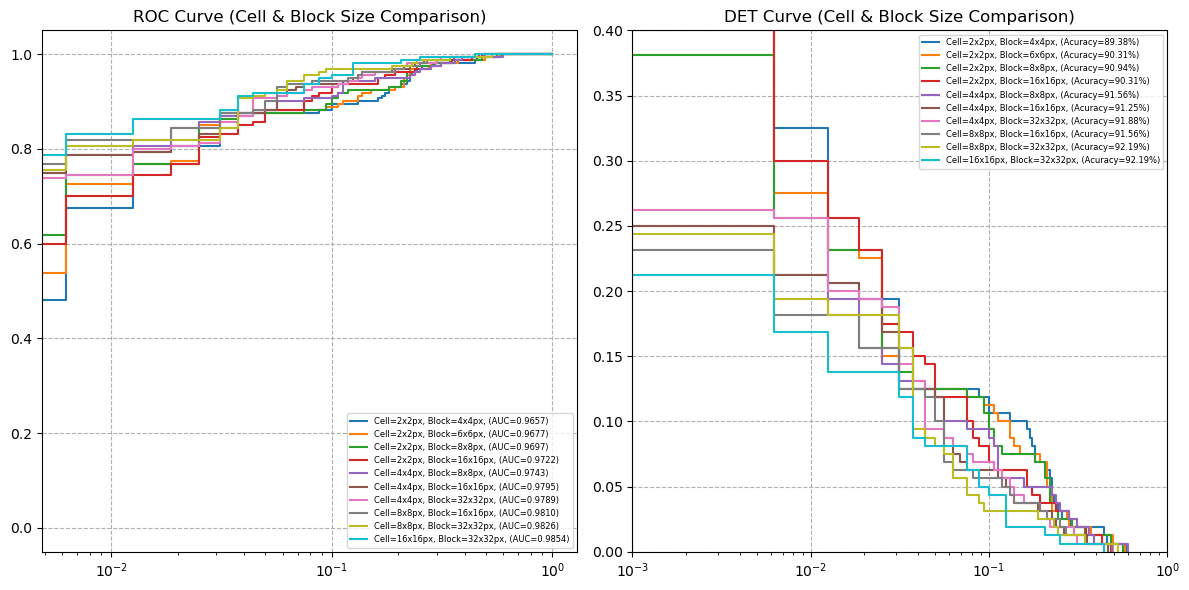

In [254]:
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(12, 6))


for i in result_3:
    ax_roc.plot(i["fpr_roc"], i["tpr_roc"], label=f"Cell={i['cell']}x{i['cell']}px, Block={i['block']}x{i['block']}px, (AUC={i['roc_auc']:.4f})")
    ax_det.plot(i["fpr_det"], i["fnr_det"], label=f"Cell={i['cell']}x{i['cell']}px, Block={i['block']}x{i['block']}px, (Acuracy={i['accuracy']:.2%})")


ax_roc.set_title("ROC Curve (Cell & Block Size Comparison)")
ax_det.set_title("DET Curve (Cell & Block Size Comparison)")

# Formatting plots
ax_det.set_xscale('log')
ax_roc.set_xscale('log')
ax_det.set_ylim(0, 0.4)
#ax_roc.set_ylim(bottom = 0.7)
ax_det.set_xlim([1e-3, 1e0])
#ax_roc.set_xlim([1e-3, 1e0])
ax_roc.grid(True, linestyle='--')
ax_det.grid(True, linestyle='--')
ax_roc.legend()
ax_det.legend()
ax_roc.legend(fontsize=6, loc = 'lower right')  
ax_det.legend(fontsize=6, loc = 'upper right')
plt.tight_layout()
plt.show()

##### 4. Step Size / Stride Ablation Study, when move the descriptor blocks, we can move the block cell by cell, or move two or more cells, or not overlap at all. 

In [255]:
block_stride_list = [ 1, 2, 4 ]
result_4 = []

In [256]:

for b in block_stride_list:
    # Recompute HOG features with different bin size
    feature_human = [compute_hog(i, cell_size=8, block_size=32, block_stride = b) for i in human_data]
    feature_non_human = [compute_hog(i, cell_size=8, block_size=32, block_stride = b) for i in non_human_data]
    
    # Combine features and labels
    predictor = np.array(feature_human + feature_non_human)
    response = np.array(human_labels + non_human_labels)
    
    # Train the classifier
    clf = LinearSVC()
    clf.fit(predictor, response)
    
    # Compute test features using same bin size
    feature_human_test = [compute_hog(i, cell_size=8, block_size=32, block_stride = b) for i in human_data_test]
    feature_non_human_test = [compute_hog(i, cell_size=8, block_size=32, block_stride = b) for i in non_human_data_test]

    predictor_test = np.array(feature_human_test + feature_non_human_test)
    response_test = np.array(human_labels_test + non_human_labels_test)

    # accuracy 
    y_pred = clf.predict(predictor_test)
    acc = accuracy_score(response_test, y_pred)

    # Plot ROC curve
    y_scores = clf.decision_function(predictor_test)
    fpr_r, tpr_r, _ = roc_curve(response_test, y_scores)
    roc_auc = auc(fpr_r, tpr_r)

    # Plot DET curve
    fpr_d, fnr_d, _ = det_curve(response_test, y_scores)
    fpr_d = np.clip(fpr_d, 1e-6, None)

    result_4.append({
        "stride": b,
        "fpr_roc": fpr_r,
        "tpr_roc": tpr_r,
        "roc_auc": roc_auc,
        "fpr_det": fpr_d,
        "fnr_det": fnr_d,
        "accuracy": acc
    })











#     # Plot ROC curve
#     y_scores = clf.decision_function(predictor_test)
#     fpr, tpr, _ = roc_curve(response_test, y_scores)
#     roc_auc = auc(fpr, tpr)
#     ax_roc.plot(fpr, tpr, label=f"Cell=8px, Block=32px, stride = {b}, (AUC={roc_auc:.4f})")


#     # Plot DET curve
#     #y_scores = clf.decision_function(predictor_test)
#     fpr, fnr, _ = det_curve(response_test, y_scores)
#     fpr = np.clip(fpr, 1e-6, None)
#     ax_det.plot(fpr, fnr, label=f"Cell=8px, Block=32px, stride = {b}")


# ax_roc.set_title("ROC Curve (Stride Comparison)")
# ax_det.set_title("DET Curve (Stride Comparison)")

# # Formatting plots
# ax_det.set_xscale('log')
# ax_roc.set_xscale('log')
# ax_det.set_ylim(0, 0.1)
# ax_roc.set_ylim(bottom = 0.5)
# ax_det.set_xlim([1e-5, 1e0])
# ax_roc.set_xlim([1e-4, 1e0])
# ax_roc.grid(True, linestyle='--')
# ax_det.grid(True, linestyle='--')
# ax_roc.legend()
# ax_det.legend()
# ax_roc.legend(fontsize=6, loc = 'lower right')  
# ax_det.legend(fontsize=6, loc = 'upper right')
# plt.tight_layout()
# plt.show()

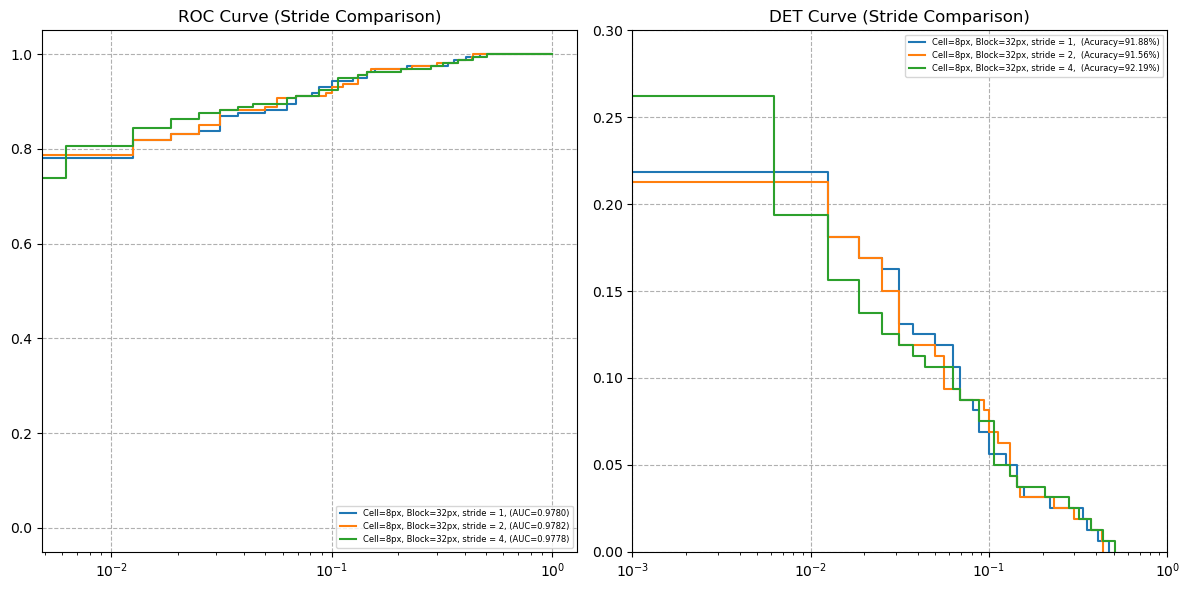

In [257]:
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(12, 6))

for i in result_4:
    ax_roc.plot(i["fpr_roc"], i["tpr_roc"], label=f"Cell=8px, Block=32px, stride = {i['stride']}, (AUC={i['roc_auc']:.4f})")
    ax_det.plot(i["fpr_det"], i["fnr_det"], label=f"Cell=8px, Block=32px, stride = {i['stride']},  (Acuracy={i['accuracy']:.2%})")


ax_roc.set_title("ROC Curve (Stride Comparison)")
ax_det.set_title("DET Curve (Stride Comparison)")

# Formatting plots
ax_det.set_xscale('log')
ax_roc.set_xscale('log')
ax_det.set_ylim(0, 0.3)
#ax_roc.set_ylim(bottom = 0.7)
ax_det.set_xlim([1e-3, 1e0])
#ax_roc.set_xlim([1e-3, 1e0])
ax_roc.grid(True, linestyle='--')
ax_det.grid(True, linestyle='--')
ax_roc.legend()
ax_det.legend()
ax_roc.legend(fontsize=6, loc = 'lower right')  
ax_det.legend(fontsize=6, loc = 'upper right')
plt.tight_layout()
plt.show()